## Notebook for playing around with the pyroomacoustic package

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

## Room Impulse Response Simulations

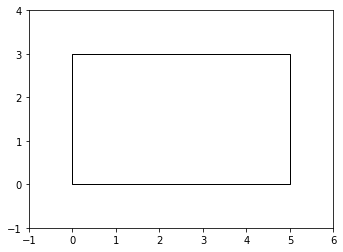

In [3]:
# Creating an arbitrary 2D room of desired dimensions by specifying corners on a plane
corners = np.array([[0,0], [5,0],[5,3],[0,3]]).T  # [x,y]
room = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

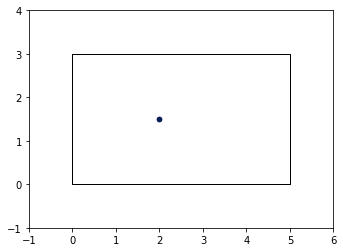

In [4]:
# Specifying sound source
fs, signal = wavfile.read("2kHz5s.wav")

# Adding source to 2D room
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
room.add_source([2,1.5], signal=signal)

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

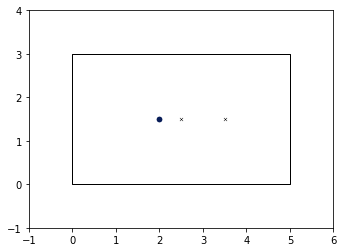

In [5]:
# Creating a linear array beamformer with 2 microphones with angle 0 degrees and inter-microphone distance 10cm
Array = pra.linear_2D_array([3, 1.5], 2, 0, 1)
room.add_microphone_array(pra.Beamformer(Array,room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

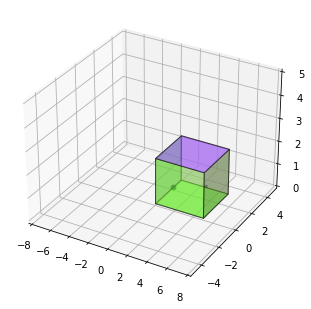

In [6]:
# Room Impulse Response (RIR) generation and propagation simulation - note that RIR = Transfer function between the sound source and the microphone

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=0, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
room.extrude(2., materials=pra.Material(0.2, 0.15))

# Set the ray tracing parameters
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([1., 1., 0.5], signal=signal)

# add two-microphone array
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])  # [[x], [y]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
ax.set_xlim([-8, 8])
ax.set_ylim([-5, 5])
ax.set_zlim([0, 5]);

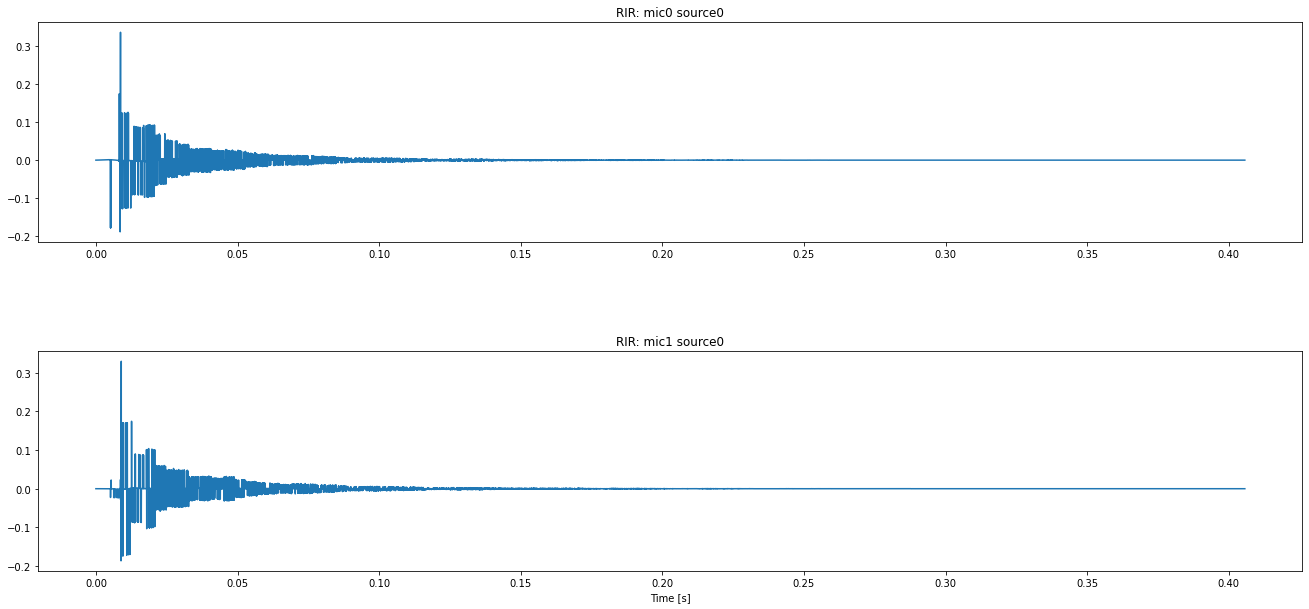

In [7]:
# Plot RIR for each microphone
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

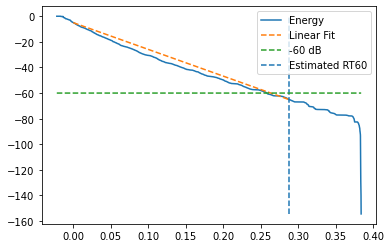

The RT60 is 287 ms


In [8]:
# Reverberation time of RIR
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [9]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 259474)


In [10]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [11]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


In [12]:
print("Simulated propagation to second mic:")
IPython.display.Audio(room.mic_array.signals[1,:], rate=fs)

Simulated propagation to second mic:


## Beamforming Simulations

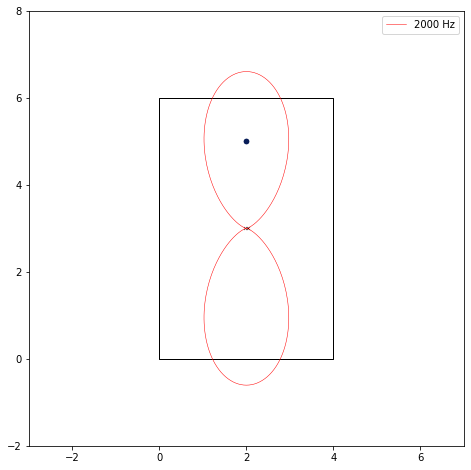

In [16]:
# Beamforming applications
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples

# specify signal source
fs, signal = wavfile.read("2kHz5sStereo.wav")

# Create 4x6 shoebox room with source and interferer and simulate
room_bf = pra.ShoeBox([4,6], fs=fs, max_order=10)
source = np.array([2, 5])
room_bf.add_source(source, delay=0., signal=signal)

# Create geometry equivalent to microphone pair array
fft_len = 512
array = pra.linear_2D_array([2, 3], 2, 0, 0.084) # ULA with 2 microphones at 0.084m spacing
mics = pra.Beamformer(array,room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# Compute DAS weights
mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])

# plot the room and resulting beamformer before simulation
fig, ax = room_bf.plot(freq=[2000], img_order=0)
ax.legend(['2000 Hz'])
ax.set_xlim([-3, 7]);
ax.set_ylim([-2, 8]);
fig.set_size_inches(20, 8);

## Direction of Arrival (DOA) Simulations

In [48]:
# Location of sources
azimuth = np.array([90, 270.]) / 180. * np.pi
distance = 2.  # meters

c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]

snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

#echo = pra.circular_2D_array(center=room_dim/2, M=20, phi0=0, radius=37.5e-3)
#echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)
#aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

ula = pra.linear_2D_array([5,5],2,0,0.1)
aroom.add_microphone_array(pra.MicrophoneArray(ula,room.fs))

# Add sources of 1 second duration
rng = np.random.RandomState(23)
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    source_signal = rng.randn(duration_samples)
    aroom.add_source(source_location, signal=source_signal)
    
# Run the simulation
aroom.simulate()

X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

algo_names = ['SRP', 'MUSIC', 'FRIDA', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](ula, fs, nfft, c=c, num_src=2, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    if algo_name is 'FRIDA':
        spatial_resp[algo_name] = np.abs(doa._gen_dirty_img())
    else:
        spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)
    
# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true locations')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
    ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)])
    
plt.show()

ValueError: could not broadcast input array from shape (48522) into shape (48521)